In [1]:
import pandas as pd
import mlflow
import json
import os
import socket
import time
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

from apps.ml.features import SensorFeatureTransformer

# MLflow setup (inside docker network use service name)
DEFAULT_TRACKING_URI = "http://mlflow:5000"
tracking_uri = os.getenv("MLFLOW_TRACKING_URI", DEFAULT_TRACKING_URI)
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("Anomaly Detection")

def wait_for_port(host: str, port: int, timeout: int = 60, interval: float = 2.0):
    start = time.time()
    while time.time() - start < timeout:
        try:
            with socket.create_connection((host, port), timeout=2):
                return True
        except OSError:
            time.sleep(interval)
    raise RuntimeError(f"MLflow not reachable at {host}:{port} after {timeout}s")

# Only wait if using the default internal URI
if "mlflow:5000" in tracking_uri:
    wait_for_port("mlflow", 5000)

print(f"MLflow tracking URI set to: {mlflow.get_tracking_uri()}")

MLflow tracking URI set to: http://mlflow:5000


In [2]:
df = pd.read_csv('data/sensor_data.csv', parse_dates=['timestamp'])

# Initialize the ENHANCED feature transformer
feature_transformer = SensorFeatureTransformer(n_lags=5, scale_columns=['value', 'quality'])
X_transformed = feature_transformer.fit_transform(df)
feature_names = feature_transformer.get_feature_names_out()

print("Data transformed successfully with new transformer.")
print(f"Features ({len(feature_names)}): {feature_names}")
X_transformed.head()

Data transformed successfully with new transformer.
Features (7): ['value_lag_1', 'value_lag_2', 'value_lag_3', 'value_lag_4', 'value_lag_5', 'value_scaled', 'quality_scaled']


/app/apps/ml/features.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.ffill().bfill())


,value_lag_1,value_lag_2,value_lag_3,value_lag_4,value_lag_5,value_scaled,quality_scaled
0,51.183,51.183,51.183,51.183,51.183,0.545164,0.726316
1,51.183,51.183,51.183,51.183,51.183,0.640252,0.526316
2,57.875,51.183,51.183,51.183,51.183,0.745130,0.821053
3,65.256,57.875,51.183,51.183,51.183,0.682396,0.747368
4,60.841,65.256,57.875,51.183,51.183,0.699092,0.694737


2025/08/18 22:56:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Registered model 'anomaly_detector_refined_v2' already exists. Creating a new version of this model...
2025/08/18 22:56:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: anomaly_detector_refined_v2, version 7


Created version '7' of model 'anomaly_detector_refined_v2'.


Run IsolationForest_v2_refined complete. Anomaly rate: 5.00%
Model registered as 'anomaly_detector_refined_v2'. Check MLflow UI.
🏃 View run IsolationForest_v2_refined at: http://mlflow:5000/#/experiments/1/runs/37083a205fd449b2b24626a487e38dab
🧪 View experiment at: http://mlflow:5000/#/experiments/1


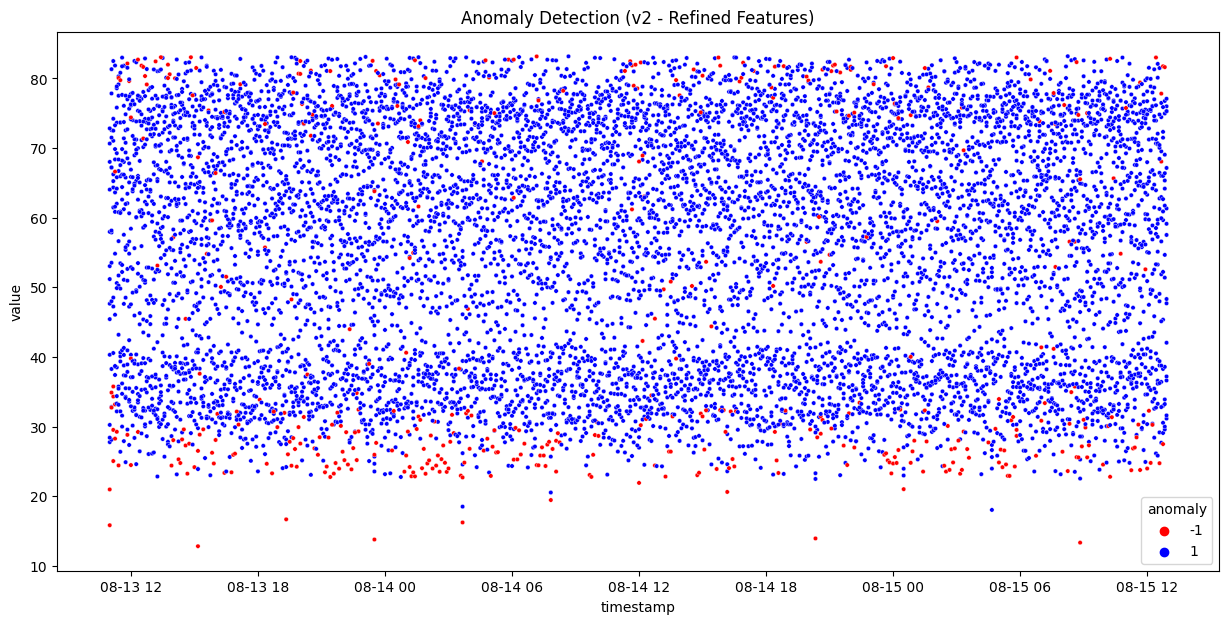

In [3]:
with mlflow.start_run(run_name="IsolationForest_v2_refined") as run:
    mlflow.log_param("model_type", "IsolationForest")
    mlflow.log_param("feature_engineering_version", "v2")

    # --- Log feature details for reproducibility ---
    mlflow.log_param("feature_count", len(feature_names))
    # Log feature names as a text artifact
    with open("feature_names.txt", "w") as f:
        json.dump(feature_names, f)
    mlflow.log_artifact("feature_names.txt")

    # --- Train Model ---
    contamination = 0.05
    mlflow.log_param("contamination", contamination)
    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(X_transformed)

    # --- Log Metrics ---
    df['anomaly'] = model.predict(X_transformed)
    anomaly_rate = (df['anomaly'] == -1).mean()
    mlflow.log_metric("anomaly_rate", anomaly_rate)
    
    # Log feature statistics as a dictionary
    feature_stats = X_transformed.describe().to_dict()
    mlflow.log_dict(feature_stats, "feature_summary_stats.json")

    # --- Log Model and Artifacts ---
    mlflow.sklearn.log_model(model, "model", registered_model_name="anomaly_detector_refined_v2")

    plt.figure(figsize=(15, 7))
    sns.scatterplot(data=df, x='timestamp', y='value', hue='anomaly', palette={1: 'blue', -1: 'red'}, s=10)
    plt.title('Anomaly Detection (v2 - Refined Features)')
    plot_path = "docs/ml/anomaly_scatter_v2.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path, "plots")

    print(f"Run {run.info.run_name} complete. Anomaly rate: {anomaly_rate:.2%}")
    print(f"Model registered as 'anomaly_detector_refined_v2'. Check MLflow UI.")